# Importing All the required Libraries

In [1]:
import pandas as pd

import re

from string import punctuation

import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize


import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.models import ldamodel

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

# Read the .csv file using Pandas. Take a look at the top few records.

In [2]:
df = pd.read_csv("../Dataset/K8 Reviews v0.2.csv")
data = df.copy()

#Creating a length of review column to analyse reviews
data['length']  = data['review'].str.len()


In [3]:
df.head()

,sentiment,review
0,1,Good but need updates and improvements
1,0,"Worst mobile i have bought ever, Battery is dr..."
2,1,when I will get my 10% cash back.... its alrea...
3,1,Good
4,0,The worst phone everThey have changed the last...


In [4]:
data.head()

,sentiment,review,length
0,1,Good but need updates and improvements,38
1,0,"Worst mobile i have bought ever, Battery is dr...",475
2,1,when I will get my 10% cash back.... its alrea...,61
3,1,Good,4
4,0,The worst phone everThey have changed the last...,156


In [5]:
print('Total number of reviews: {}'.format(len(data.length)))
print('Reviews with less than 500 words: {}'.format(len(data[data.length <500].length)))

Total number of reviews: 14675
Reviews with less than 500 words: 14239


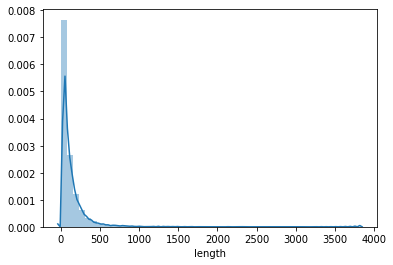

In [6]:
sns.distplot(data.length)

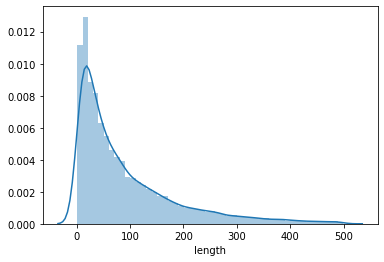

In [7]:
sns.distplot(data[data.length <500].length)

# Normalize casings for the review text and extract the text into a list for easier manipulation.

In [8]:
df_lower = [rev.lower() for rev in df.review.values]

In [9]:
df_lower[0]

'good but need updates and improvements'

# Tokenize the reviews using NLTKs word_tokenize function.

In [10]:
%%time
df_token = [word_tokenize(rev) for rev in df_lower]

Wall time: 3.45 s


In [11]:
df_token[0]

['good', 'but', 'need', 'updates', 'and', 'improvements']

# Perform parts-of-speech tagging on each sentence using the NLTK POS tagger.

In [12]:
%%time
df_tagged = [nltk.pos_tag(tokens) for tokens in df_token]

Wall time: 29 s


In [13]:
df_tagged[0]

[('good', 'JJ'),
 ('but', 'CC'),
 ('need', 'VBP'),
 ('updates', 'NNS'),
 ('and', 'CC'),
 ('improvements', 'NNS')]

# For the topic model, we should  want to include only nouns.

## Find out all the POS tags that correspond to nouns.

In [14]:
# nltk.help.upenn_tagset()

In [15]:
# NN: noun, common, singular or mass
#     common-carrier cabbage knuckle-duster Casino afghan shed thermostat
#     investment slide humour falloff slick wind hyena override subhumanity
#     machinist ...
# NNP: noun, proper, singular
#     Motown Venneboerger Czestochwa Ranzer Conchita Trumplane Christos
#     Oceanside Escobar Kreisler Sawyer Cougar Yvette Ervin ODI Darryl CTCA
#     Shannon A.K.C. Meltex Liverpool ...
# NNPS: noun, proper, plural
#     Americans Americas Amharas Amityvilles Amusements Anarcho-Syndicalists
#     Andalusians Andes Andruses Angels Animals Anthony Antilles Antiques
#     Apache Apaches Apocrypha ...
# NNS: noun, common, plural
#     undergraduates scotches bric-a-brac products bodyguards facets coasts
#     divestitures storehouses designs clubs fragrances averages
#     subjectivists apprehensions muses factory-jobs ...

## Limit the data to only terms with these tags.

In [16]:
df_noun = []

In [17]:
%%time
for rev in df_tagged:
    df_noun.append([token for token in rev if re.search("NN.*", token[1])])

Wall time: 380 ms


In [18]:
df_noun[0]

[('updates', 'NNS'), ('improvements', 'NNS')]

# Lemmatize

## Different forms of the terms need to be treated as one.

In [19]:
lemm = WordNetLemmatizer()

In [20]:
df_lemm = []
df_noun[0]

[('updates', 'NNS'), ('improvements', 'NNS')]

## No need to provide POS tag to lemmatizer for now.

In [21]:
%%time
for nn in df_noun:
    df_lemm.append([lemm.lemmatize(word[0]) for word in nn])

Wall time: 2.91 s


In [22]:
df_lemm[0]

['update', 'improvement']

# Remove stopwords and punctuation (if there are any). 

In [23]:
stop_nltk = stopwords.words("english")

In [24]:
stop_updated = stop_nltk + list(punctuation) + ["..."] + [".."]

In [25]:
df_sw_removed = []

In [26]:
%%time
for rev in df_lemm:
    df_sw_removed.append([term for term in rev if term not in stop_updated])

Wall time: 427 ms


In [27]:
df_lemm[1]

['mobile',
 'i',
 'battery',
 'hell',
 'backup',
 'hour',
 'us',
 'idle',
 'discharged.this',
 'lie',
 'amazon',
 'lenove',
 'battery',
 'charger',
 'hour',
 'don']

In [28]:
df_sw_removed[1]

['mobile',
 'battery',
 'hell',
 'backup',
 'hour',
 'us',
 'idle',
 'discharged.this',
 'lie',
 'amazon',
 'lenove',
 'battery',
 'charger',
 'hour']

# Create a topic model using LDA on the cleaned-up data with 12 topics.

## Print out the top terms for each topic.

In [29]:
id2word = corpora.Dictionary(df_sw_removed)

In [30]:
texts = df_sw_removed

In [31]:
corpus = [id2word.doc2bow(text) for text in texts]

In [32]:
print(corpus[0])

[(0, 1), (1, 1)]


In [72]:
%%time
lda_model_12 = gensim.models.ldamodel.LdaModel(
    corpus=corpus, id2word=id2word, num_topics=12, random_state=11, passes=10, per_word_topics=True)

Wall time: 27.7 s


In [63]:
# print(lda_model.print_topics())

## What is the coherence of the model with the c_v metric?

In [73]:
%%time
coherence_model_lda_12 = CoherenceModel(
    model=lda_model_12, texts=df_sw_removed, dictionary=id2word, coherence='c_v')
coherence_lda_12 = coherence_model_lda_12.get_coherence()

Wall time: 7.82 s


In [74]:
print('\nCoherence Score: ', coherence_lda_12)


Coherence Score:  0.5233221234972307


# Analyze the topics through the business lens.

## Determine which of the topics can be combined.

Looking at the topics and each terms following can be combined –
- Topic 2 and 5 possibly talks about 'pricing'
- Topic 4, 6 and 10 closely talks about 'battery related issues'
- Topic 3 and 11 vaguely talks about 'performance'

In [76]:
x = lda_model_12.show_topics(formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]
for topic, words in topics_words:
    print(str(topic) + "::" + str(words))

0::['hai', 'h', 'music', 'dolby', 'headphone', 'ho', 'atmos', 'class', 'item', 'k']
5::['product', 'amazon', 'service', 'customer', 'replacement', 'return', 'everything', 'day', 'lenovo', 'care']
10::['update', 'software', 'system', 'android', 'stock', 'bit', 'version', 'buy', 'music', 'cell']
1::['problem', 'heating', 'handset', 'issue', 'network', 'excellent', 'please', 'connection', 'order', 'hanging']
6::['camera', 'quality', 'phone', 'money', 'waste', 'value', 'superb', 'feature', 'photo', 'mark']
2::['phone', 'time', 'battery', 'day', 'hour', 'issue', 'device', 'heat', 'use', 'charge']
4::['issue', 'charger', 'network', 'turbo', 'charging', 'sim', 'jio', 'smartphone', 'volta', 'piece']
11::['battery', 'camera', 'backup', 'quality', 'speaker', 'life', 'sound', 'drain', 'picture', 'speed']
3::['phone', 'price', 'note', 'lenovo', 'feature', 'range', 'delivery', 'review', 'budget', 'center']
8::['mobile', 'note', 'k8', 'lenovo', 'glass', 'gorilla', 'ok', 'pls', 'bill', 'offer']


In [77]:
for tp in x:
    print(tp[0])

0
5
10
1
6
2
4
11
3
8


# Create topic model using LDA with what you think is the optimal number of topics



In [79]:
# #For Loop Trick
# for j in range(4,13):
#     for i in range(1,101):
#         print('n_topics:{} r_state: {}'.format(j,i))
#         lda_model = gensim.models.ldamodel.LdaModel(
#             corpus=corpus, id2word=id2word, num_topics=j, random_state=i, passes=10, per_word_topics=True)

#         coherence_model_lda = CoherenceModel(
#         model=lda_model, texts=df_sw_removed, dictionary=id2word, coherence='c_v')

#         coherence_lda = coherence_model_lda.get_coherence()

#         if coherence_lda > 0.4:
#             print('n_topics: {} random state:{},coherence: {}'.format(j,i,coherence_lda))

In [55]:
# n_topics: 5 random state: 6, coherence: 0.608313724768627
# n_topics: 5 random state: 21, coherence: 0.6010029024766205
# n_topics: 5 random state: 23, coherence: 0.6161342433171327   <----- Chosen Model with 5 Topics
# n_topics: 5 random state: 44, coherence: 0.6113376791326737
# n_topics: 5 random state: 88, coherence: 0.6071179913493188

In [107]:
%%time
lda_model_5 = gensim.models.ldamodel.LdaModel(
    corpus=corpus, id2word=id2word, num_topics=5, random_state=23, passes=50, per_word_topics=True)

Wall time: 2min 17s


## What is the coherence of the model?



In [110]:
%%time
coherence_model_lda_5 = CoherenceModel(
    model=lda_model_5, texts=df_sw_removed, dictionary=id2word, coherence='c_v')
coherence_lda_5 = coherence_model_lda_5.get_coherence()

Wall time: 7.18 s


In [111]:
print('\nCoherence Score: ', coherence_lda_5)

# Coherence Score:  0.6131793897634481


Coherence Score:  0.6131793897634481


# The business should  be able to interpret the topics.

## Name each of the identified topics.

In [86]:
x = lda_model_5.show_topics(formatted=False)
print('Total number of Topics Identified: {}'.format(len(x)))
for tp in x:
    print('Topic: {}'.format(tp[0]))

Total number of Topics Identified: 5
Topic: 0
Topic: 1
Topic: 2
Topic: 3
Topic: 4


## Create a table with the topic name and the top 10 terms in each to present to the  business.

In [98]:
top_10 = []
x = lda_model_5.show_topics(formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]
for topic, words in topics_words:
    top_10.append(words)
    print(str(topic) + "::" + str(words))

0::['battery', 'phone', 'camera', 'performance', 'backup', 'charger', 'day', 'life', 'hour', 'issue']
1::['note', 'k8', 'phone', 'screen', 'lenovo', 'call', 'handset', 'option', 'feature', 'glass']
2::['product', 'phone', 'problem', 'issue', 'time', 'heating', 'network', 'amazon', 'battery', 'service']
3::['phone', 'money', 'value', 'delivery', 'hai', 'h', 'feature', 'budget', 'superb', 'worth']
4::['camera', 'mobile', 'quality', 'price', 'feature', 'range', 'video', 'sound', 'photo', 'picture']


In [103]:
bNames = ['Accessories', 'Software', 'Hardware', 'Pricing', 'Specs'] 

In [101]:
table = pd.DataFrame(list(zip(bNames, top_10)), columns =['Business Names', 'Trending topics'])

In [102]:
table

,Business Names,Trending topics
0,Accessories,"[battery, phone, camera, performance, backup, ..."
1,Software,"[note, k8, phone, screen, lenovo, call, handse..."
2,Hardware,"[product, phone, problem, issue, time, heating..."
3,Pricing,"[phone, money, value, delivery, hai, h, featur..."
4,Specs,"[camera, mobile, quality, price, feature, rang..."
